# Stock Price Prediction with Prophet

In this notebook, we demonstrate a reference use case where we use historical stock price data to predict the future price using the Prophet model. The dataset we use is the daily stock price of S&P500 stocks during 2013-2018 ([data source](https://www.kaggle.com/camnugent/sandp500/)). 

Reference: https://facebook.github.io/prophet, https://github.com/jwkanggist/tf-keras-stock-pred

## Get Data

We will use the close prices of MMM stock for our experiment. We will 
  1. download raw dataset and load into dataframe. 
  2. change the column name of the dataframe to fit the input structure of Prophet

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
FILE_NAME    = 'all_stocks_5yr.csv'
SOURCE_URL   = 'https://github.com/CNuge/kaggle-code/raw/master/stock_data/' 

filepath = './data/'+ FILE_NAME
filepath = os.path.join('data', FILE_NAME)
print(filepath)

data/all_stocks_5yr.csv


In [3]:
# download data
!if ! [ -d "data" ]; then mkdir data; cd data; wget https://github.com/CNuge/kaggle-code/raw/master/stock_data/individual_stocks_5yr.zip; wget https://raw.githubusercontent.com/CNuge/kaggle-code/master/stock_data/merge.sh; chmod +x merge.sh; unzip individual_stocks_5yr.zip; ./merge.sh; fi

In [4]:
# read data
data = pd.read_csv(filepath)
print(data[:10])

         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
5  2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL
6  2013-02-19  14.33  14.56  14.08  14.26  11354400  AAL
7  2013-02-20  14.17  14.26  13.15  13.33  14725200  AAL
8  2013-02-21  13.62  13.95  12.90  13.37  11922100  AAL
9  2013-02-22  13.57  13.60  13.21  13.57   6071400  AAL


In [5]:
# change input column name 
data = data[data['Name']=='MMM'].rename(columns={"date":"ds", "close":"y"})
data.head()

,ds,open,high,low,y,volume,Name
381385,2013-02-08,102.34,103.330,102.0400,102.66,1937721,MMM
381386,2013-02-11,102.39,102.880,102.0401,102.62,1715444,MMM
381387,2013-02-12,102.66,103.590,102.6300,103.46,1927930,MMM
381388,2013-02-13,103.03,103.395,102.5800,102.86,1699804,MMM
381389,2013-02-14,102.43,103.140,102.2200,102.78,2217419,MMM


## Data Pre-processing
Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset.

For the stock price data we're using, we add normlization such that the normalized stock prices fall in the range of 0 to 1. And here we aims at using historical values to predict stock prices of future 24 days.

In [6]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    """
    Use sklearn.preprocessing.MinMaxScaler() to normalize data (min = 0, max = 1)
        1. X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        2. X_scaled = X_std * (max - min) + min
    """
    data_normalized = MinMaxScaler().fit_transform(data)
    return data_normalized

data_nor = data.copy()
data_nor['y'] = normalize_data(data_nor[['y']].values)

In [7]:
data_train, data_test = data_nor[:-24], data_nor[-24:]
print(data_train.shape[0])
print(data_test.shape[0])

1235
24


In [8]:
def get_data(data_train, data_test):
    data = {'x': data_train, 'y': None, 'val_x': None, 'val_y': data_test}
    return data

data = get_data(data_train, data_test)

## Prophet Model Demonstration
Here we provide a simple demonstration of basic operations with the Prophet model.

In [9]:
from zoo.chronos.model.prophet import ProphetModel

In [10]:
model = ProphetModel()
val_mse = model.fit_eval(data=data)
print(f"Validation MSE = {val_mse}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Validation MSE = 0.003005772477948971


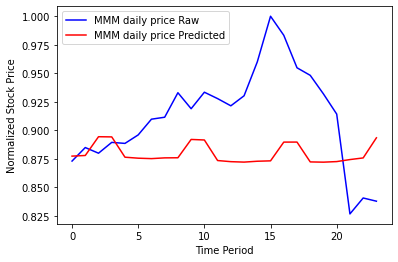

In [11]:
# Plot predictions
pred = model.predict(horizon=data_test.shape[0])

import matplotlib.pyplot as plt
plt.plot(data_nor[['y']].values[-data_test.shape[0]:], color='blue', label="MMM daily price Raw")
plt.plot(pred[['yhat']].values, color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()

## AutoProphet Demonstration
Here we provide a demonstration of our AutoProphet AutoEstimator that could search for best hyperparameters for the model automatically.

In [12]:
from zoo.chronos.autots.model.AutoProphet import AutoProphet
from zoo.automl.recipe.base import Recipe
from zoo.orca.automl import hp
from zoo.orca import init_orca_context

In [13]:
init_orca_context(init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/changyuan/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/changyuan/Projects/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-dist-all/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.10.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-05-20 09:45:18,009	INFO services.py:1174 -- View the Ray dashboard at http://10.239.166.12:8265


{'node_ip_address': '10.239.166.12', 'raylet_ip_address': '10.239.166.12', 'redis_address': '10.239.166.12:6379', 'object_store_address': '/tmp/ray/session_2021-05-20_09-45-16_677432_26120/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-05-20_09-45-16_677432_26120/sockets/raylet', 'webui_url': '10.239.166.12:8265', 'session_dir': '/tmp/ray/session_2021-05-20_09-45-16_677432_26120', 'metrics_export_port': 60942, 'node_id': 'dc303e04edab7e6810f848539ec45987f24292e45efb4c0f3a994656'}


<SparkContext master=local[2] appName=pyspark-shell>

In [14]:
auto_prophet = AutoProphet()
# model = AutoProphet(cpus_per_trial=2, name="auto_prophet")

epochs = 1
n_sampling = 10
search_space = {
    "changepoint_prior_scale": hp.loguniform(0.001, 0.5),
    "seasonality_prior_scale": hp.loguniform(0.01, 10),
    "holidays_prior_scale": hp.loguniform(0.01, 10),
    "seasonality_mode": hp.choice(['additive', 'multiplicative']),
    "changepoint_range": hp.uniform(0.8, 0.95)
}

search_alg = None
search_alg_params = None
scheduler = None
scheduler_params = None

auto_prophet.fit(data=data,
          epochs=1,
          metric="mse",
          n_sampling=10,
          search_space=search_space,
          search_alg=search_alg,
          search_alg_params=search_alg_params,
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          )

2021-05-20 09:45:44,351	INFO tune.py:450 -- Total run time: 24.70 seconds (24.65 seconds for the tuning loop).


In [15]:
print("Training completed.")
best_model = auto_prophet.get_best_model()
y_hat = best_model.predict()

Training completed.


In [16]:
# Print best hyperparameters
print(best_model.model.changepoint_prior_scale)
print(best_model.model.seasonality_prior_scale)
print(best_model.model.holidays_prior_scale)
print(best_model.model.seasonality_mode)
print(best_model.model.changepoint_range)

0.12784892529812272
7.977144392551142
0.1999662507927439
additive
0.8208184632046521


In [17]:
assert best_model.model.seasonality_mode in ['additive', 'multiplicative']

In [18]:
test_mse = best_model.evaluate(x=None, target=data_test)[0].item()
print(f"Validation MSE = {test_mse}")

Validation MSE = 0.002651969423873537


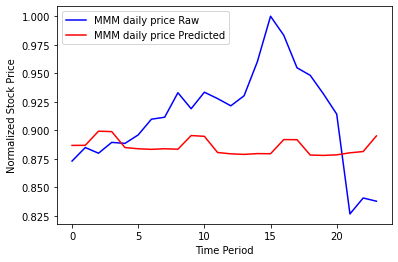

In [19]:
# Plot predictions
import matplotlib.pyplot as plt
plt.plot(data_nor[['y']].values[-data_test.shape[0]:], color='blue', label="MMM daily price Raw")
plt.plot(y_hat[['yhat']].values, color='red', label="MMM daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.show()